# example code for training and evaluating hmm models


## define imports and constants


In [1]:
import sys
from pathlib import Path

# get project root for file paths and add project root to python path so imports work from notebooks folder
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from hmm.preprocess import build_sequences_from_csv
from hmm.hmm_model import (
    train_supervised_hmm,
    train_unsupervised_hmm,
    sequence_accuracy,
    map_hidden_states_to_outcomes,
    convert_hidden_to_observed,
    infer_num_symbols,
)
from hmm.hmm_viterbi import viterbi_on_sequences

import numpy as np
import matplotlib.pyplot as plt

# constants
DATA_PATH = str(PROJECT_ROOT / "data" / "allseasons.csv")  # path where game data is stored
HOLDOUT_SEASONS = (2018, 2024)  # test set seasons
NUM_STATES_SUPERVISED = 2  # 0 = loss, 1 = win (if 2 states, else state to win/loss mapping is done later)
NUM_STATES_UNSUPERVISED = 90
NUM_BINS_SUPERVISED = 8
NUM_BINS_UNSUPERVISED = 3
DEAN = False

# notebook plotting defaults
plt.style.use("seaborn-v0_8")
%matplotlib inline


## load and inspect sequences


In [2]:
# build sequences using specified holdout seasons for supervised training
(
    train_states_supervised,
    train_obs_supervised,
    test_states_supervised,
    test_obs_supervised,
    train_seasons_supervised,
    test_seasons_supervised,
) = build_sequences_from_csv(
    DATA_PATH,
    holdout_seasons=HOLDOUT_SEASONS,
    num_bins=NUM_BINS_SUPERVISED,
    dean=DEAN,
)

# build sequences using specified holdout seasons for unsupervised training
(
    train_states_unsupervised,
    train_obs_unsupervised,
    test_states_unsupervised,
    test_obs_unsupervised,
    train_seasons_unsupervised,
    test_seasons_unsupervised,
) = build_sequences_from_csv(
    DATA_PATH,
    holdout_seasons=HOLDOUT_SEASONS,
    num_bins=NUM_BINS_UNSUPERVISED,
    dean=DEAN,
)

print(f"num train sequences: {len(train_states_supervised)}")
print(f"num test sequences: {len(test_states_supervised)}")

# compute basic length statistics for sequences
train_lengths = [s.size for s in train_states_supervised]
test_lengths = [s.size for s in test_states_supervised]

print()
print("train sequence length stats (min / max / mean):",
      np.min(train_lengths), np.max(train_lengths), np.mean(train_lengths))
print("test sequence length stats (min / max / mean):",
      np.min(test_lengths), np.max(test_lengths), np.mean(test_lengths))


num train sequences: 686
num test sequences: 60

train sequence length stats (min / max / mean): 63 84 80.08746355685132
test sequence length stats (min / max / mean): 81 83 81.9


## train supervised hmm


In [3]:
# choose training routine based on requested number of states
num_symbols_supervised = infer_num_symbols(train_obs_supervised)
unique_train_labels_supervised = sorted(
    {int(label) for seq in train_states_supervised for label in np.unique(seq)}
)

pi_supervised, A_supervised, B_supervised = train_supervised_hmm(
    state_sequences=train_states_supervised,
    obs_sequences=train_obs_supervised,
    num_states=NUM_STATES_SUPERVISED,
    num_symbols=num_symbols_supervised,
)

print(f"training mode: supervised mle")

print("initial state distribution (pi):")
print(pi_supervised)
print()

print("transition matrix (A):")
print(A_supervised)
print()

print("emission matrix (B):")
print(B_supervised)
print()

print("shapes -> pi:", pi_supervised.shape, ", A:", A_supervised.shape, ", B:", B_supervised.shape)


training mode: supervised mle
initial state distribution (pi):
[0.49127907 0.50872093]

transition matrix (A):
[[0.54212292 0.45787708]
 [0.45811682 0.54188318]]

emission matrix (B):
[[0.22989301 0.19812213 0.16798894 0.13887474 0.1114346  0.07955455
  0.05258752 0.02154451]
 [0.02012519 0.05247835 0.08177451 0.11216246 0.13712788 0.16999054
  0.19819492 0.22814615]]

shapes -> pi: (2,) , A: (2, 2) , B: (2, 8)


## train unsupervised hmm

In [4]:
# choose training routine based on requested number of states
num_symbols_unsupervised = infer_num_symbols(train_obs_unsupervised)
unique_train_labels_unsupervised = sorted(
    {int(label) for seq in train_states_unsupervised for label in np.unique(seq)}
)

pi_unsupervised, A_unsupervised, B_unsupervised, log_likelihoods = train_unsupervised_hmm(
    obs_sequences=train_obs_unsupervised,
    num_states=NUM_STATES_UNSUPERVISED,
    num_symbols=num_symbols_unsupervised,
    smoothing=1e-3,
    max_iters=75,
    tol=1e-3,
    random_state=0,
)


print(f"training mode: unsupervised (baum-welch)")
print(
    f"final log-likelihood: {log_likelihoods[-1]:.2f} after {len(log_likelihoods)} iterations"
)

print("initial state distribution (pi):")
print(pi_unsupervised)
print()

print("transition matrix (A):")
print(A_unsupervised)
print()

print("emission matrix (B):")
print(B_unsupervised)
print()

print("shapes -> pi:", pi_unsupervised.shape, ", A:", A_unsupervised.shape, ", B:", B_unsupervised.shape)


training mode: unsupervised (baum-welch)
final log-likelihood: 59870.12 after 75 iterations
initial state distribution (pi):
[2.75695326e-03 4.50153685e-03 1.74692293e-04 7.32867813e-05
 5.92606552e-03 8.00726742e-03 2.55185486e-03 1.49381777e-02
 4.98499666e-02 8.42462544e-03 1.62046383e-02 8.03183800e-05
 1.28081309e-02 5.45863030e-04 1.28595057e-02 1.01244203e-02
 2.01832705e-02 5.02917945e-03 2.70378271e-03 1.66287236e-02
 2.17731370e-04 5.86423540e-04 1.57800757e-03 2.71590061e-03
 3.54944380e-03 5.97719935e-04 1.92579584e-03 1.66493533e-02
 2.54808718e-03 1.80478087e-03 1.54350158e-03 9.36584944e-03
 6.16762727e-03 1.31072441e-03 4.60545989e-03 1.04628769e-02
 1.26307177e-02 1.58486717e-03 2.41038560e-02 2.51739943e-02
 2.34199435e-02 7.85537485e-03 7.94102619e-04 3.68987814e-03
 1.21971275e-03 2.93414164e-03 5.04367725e-04 3.38806354e-02
 1.87233971e-02 4.54860053e-03 3.69437874e-02 5.80796587e-04
 3.32555004e-03 1.03727981e-03 6.02808822e-03 1.83326829e-02
 2.83504817e-03 3.247

map hidden hmm states to win/loss outcomes for model trained unsupervised

In [5]:
# map hidden hmm states to win/loss outcomes when using unsupervised training
state_mapping = None
train_hidden_paths = viterbi_on_sequences(
    emissions=B_unsupervised,
    initials=pi_unsupervised,
    transitions=A_unsupervised,
    obs_sequences=train_obs_unsupervised,
)
state_mapping = map_hidden_states_to_outcomes(
    hidden_sequences=train_hidden_paths,
    true_sequences=train_states_unsupervised,
    num_hidden_states=NUM_STATES_UNSUPERVISED,
)
mapped_train_paths = convert_hidden_to_observed(train_hidden_paths, state_mapping)
train_macro_acc = sequence_accuracy(train_states_unsupervised, mapped_train_paths)
print("hidden state to outcome mapping:", state_mapping)
print(f"train accuracy after mapping: {train_macro_acc:.3f}")



hidden state to outcome mapping: [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1]
train accuracy after mapping: 0.714


## run viterbi decoding on test data and compute accuracy


## supervised model

In [6]:
# run viterbi on test observation sequences
pred_paths_supervised = viterbi_on_sequences(
    emissions=B_supervised,
    initials=pi_supervised,
    transitions=A_supervised,
    obs_sequences=test_obs_supervised,
)

# compute overall test accuracy
overall_acc_supervised = sequence_accuracy(test_states_supervised, pred_paths_supervised)
print("overall test accuracy (supervised):", overall_acc_supervised)

# compute per-sequence accuracies and keep track of seasons and indices
per_seq_accs_supervised = []
per_seq_seasons_supervised = []
per_seq_indices_supervised = []

for idx, (season, y_true, y_pred) in enumerate(
    zip(test_seasons_supervised, test_states_supervised, pred_paths_supervised)
):
    if y_true.size == 0 or y_pred.size == 0:
        continue
    T = min(y_true.size, y_pred.size)
    acc = np.mean(y_true[:T] == y_pred[:T])
    per_seq_accs_supervised.append(acc)
    per_seq_seasons_supervised.append(season)
    per_seq_indices_supervised.append(idx)

per_seq_accs_supervised = np.array(per_seq_accs_supervised)
per_seq_seasons_supervised = np.array(per_seq_seasons_supervised)
per_seq_indices_supervised = np.array(per_seq_indices_supervised, dtype=int)

print("mean per-sequence accuracy (supervised):", per_seq_accs_supervised.mean())
print("median per-sequence accuracy (supervised):", np.median(per_seq_accs_supervised))
print()

# run viterbi on test observation sequences
raw_pred_paths = viterbi_on_sequences(
    emissions=B_unsupervised,
    initials=pi_unsupervised,
    transitions=A_unsupervised,
    obs_sequences=test_obs_unsupervised,
)
pred_paths_unsupervised = convert_hidden_to_observed(raw_pred_paths, state_mapping)

# compute overall test accuracy
overall_acc_unsupervised = sequence_accuracy(test_states_unsupervised, pred_paths_unsupervised)
print("overall test accuracy (unsupervised):", overall_acc_unsupervised)

# compute per-sequence accuracies and keep track of seasons and indices
per_seq_accs_unsupervised = []
per_seq_seasons_unsupervised = []
per_seq_indices_unsupervised = []

for idx, (season, y_true, y_pred) in enumerate(
    zip(test_seasons_unsupervised, test_states_unsupervised, pred_paths_unsupervised)
):
    if y_true.size == 0 or y_pred.size == 0:
        continue
    T = min(y_true.size, y_pred.size)
    acc = np.mean(y_true[:T] == y_pred[:T])
    per_seq_accs_unsupervised.append(acc)
    per_seq_seasons_unsupervised.append(season)
    per_seq_indices_unsupervised.append(idx)

per_seq_accs_unsupervised = np.array(per_seq_accs_unsupervised)
per_seq_seasons_unsupervised = np.array(per_seq_seasons_unsupervised)
per_seq_indices_unsupervised = np.array(per_seq_indices_unsupervised, dtype=int)

print("mean per-sequence accuracy (unsupervised):", per_seq_accs_unsupervised.mean())
print("median per-sequence accuracy (unsupervised):", np.median(per_seq_accs_unsupervised))


overall test accuracy (supervised): 0.7411477411477412
mean per-sequence accuracy (supervised): 0.7411343053635802
median per-sequence accuracy (supervised): 0.7378048780487805

overall test accuracy (unsupervised): 0.7234432234432234
mean per-sequence accuracy (unsupervised): 0.7233962952079318
median per-sequence accuracy (unsupervised): 0.7239536284251731


## unsupervised model

## visualize per-sequence accuracy distribution


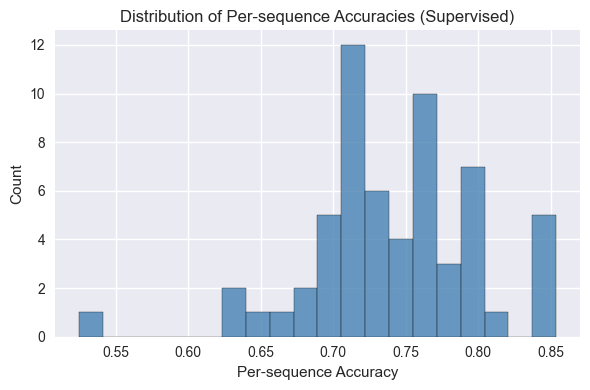

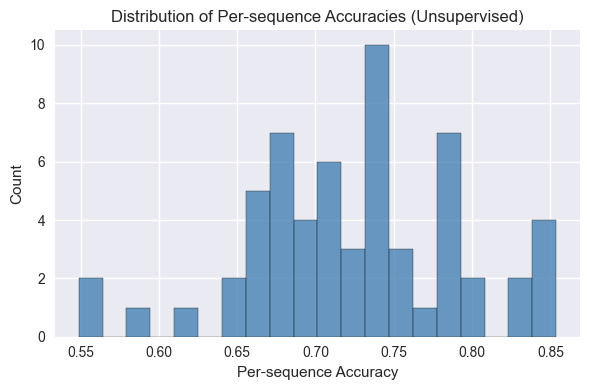

In [8]:
# plot histogram of per-sequence accuracies
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(per_seq_accs_supervised, bins=20, color="steelblue", edgecolor="black", alpha=0.8)
ax.set_xlabel("Per-sequence Accuracy")
ax.set_ylabel("Count")
ax.set_title("Distribution of Per-sequence Accuracies (Supervised)")
plt.tight_layout()
plt.show()

# plot histogram of per-sequence accuracies
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(per_seq_accs_unsupervised, bins=20, color="steelblue", edgecolor="black", alpha=0.8)
ax.set_xlabel("Per-sequence Accuracy")
ax.set_ylabel("Count")
ax.set_title("Distribution of Per-sequence Accuracies (Unsupervised)")
plt.tight_layout()
plt.show()



## confusion matrix of predicted vs true state


Confusion Matrix (Supervised) (rows = true, cols = predicted):
[[1820  637]
 [ 635 1822]]


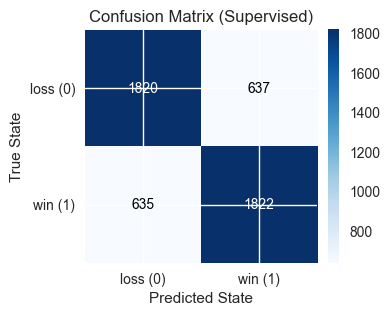

Confusion Matrix (Unsupervised) (rows = true, cols = predicted):
[[1940  517]
 [ 842 1615]]


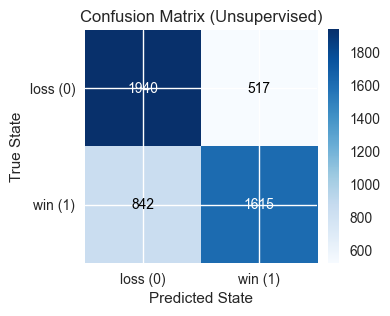

In [9]:
# build confusion matrix over all test games
num_outcomes = len(unique_train_labels_supervised)
confusion = np.zeros((num_outcomes, num_outcomes), dtype=int)

for y_true, y_pred in zip(test_states_supervised, pred_paths_supervised):
    if y_true.size == 0 or y_pred.size == 0:
        continue
    T = min(y_true.size, y_pred.size)
    for t in range(T):
        confusion[y_true[t], y_pred[t]] += 1

print("Confusion Matrix (Supervised) (rows = true, cols = predicted):")
print(confusion)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(confusion, cmap="Blues")

ax.set_xticks(range(num_outcomes))
ax.set_yticks(range(num_outcomes))
labels = ["loss (0)", "win (1)"][:num_outcomes]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted State")
ax.set_ylabel("True State")
ax.set_title("Confusion Matrix (Supervised)")

# use white text on dark cells and black text on light cells
thresh = confusion.max() / 2.0
for i in range(num_outcomes):
    for j in range(num_outcomes):
        color = "white" if confusion[i, j] > thresh else "black"
        ax.text(j, i, confusion[i, j], ha="center", va="center", color=color)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# build confusion matrix over all test games
num_outcomes = len(unique_train_labels_unsupervised)
confusion = np.zeros((num_outcomes, num_outcomes), dtype=int)

for y_true, y_pred in zip(test_states_unsupervised, pred_paths_unsupervised):
    if y_true.size == 0 or y_pred.size == 0:
        continue
    T = min(y_true.size, y_pred.size)
    for t in range(T):
        confusion[y_true[t], y_pred[t]] += 1

print("Confusion Matrix (Unsupervised) (rows = true, cols = predicted):")
print(confusion)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(confusion, cmap="Blues")

ax.set_xticks(range(num_outcomes))
ax.set_yticks(range(num_outcomes))
labels = ["loss (0)", "win (1)"][:num_outcomes]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted State")
ax.set_ylabel("True State")
ax.set_title("Confusion Matrix (Unsupervised)")

# use white text on dark cells and black text on light cells
thresh = confusion.max() / 2.0
for i in range(num_outcomes):
    for j in range(num_outcomes):
        color = "white" if confusion[i, j] > thresh else "black"
        ax.text(j, i, confusion[i, j], ha="center", va="center", color=color)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()



## example seasons: true vs predicted states


Top example (rank 1 of 60). visualizing sequence: season 2018, index 14, accuracy 0.854, length 82


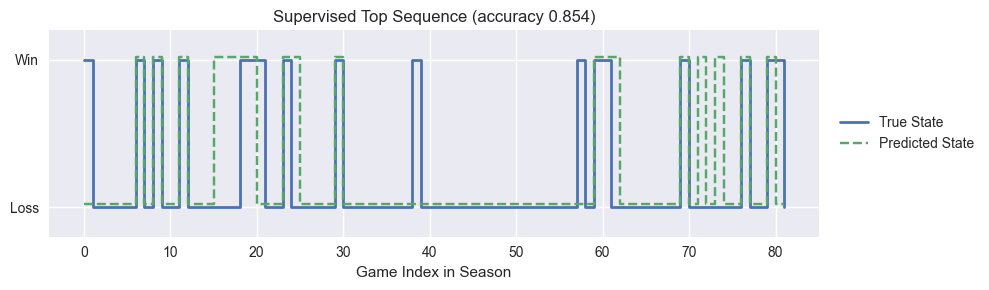

Median example (rank 29 of 60). visualizing sequence: season 2024, index 37, accuracy 0.744, length 82


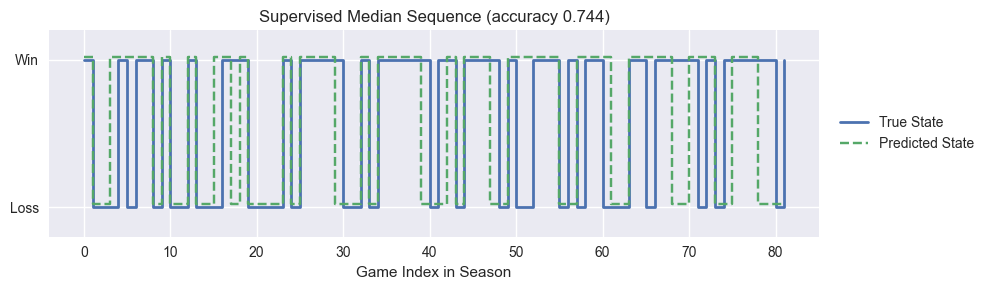

Worst example (rank 60 of 60). visualizing sequence: season 2018, index 20, accuracy 0.524, length 82


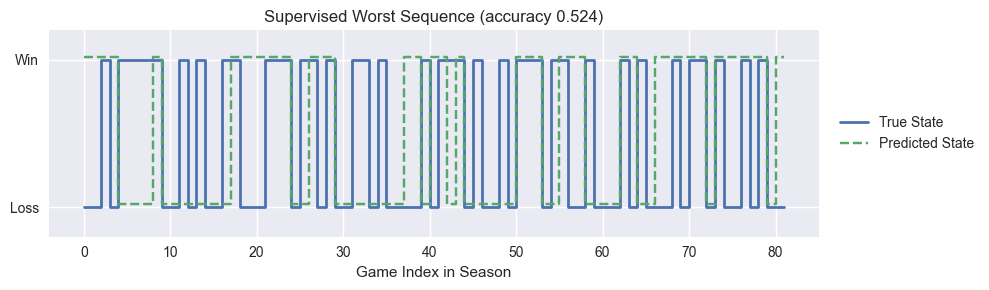

Top example (rank 1 of 60). visualizing sequence: season 2018, index 14, accuracy 0.854, length 82


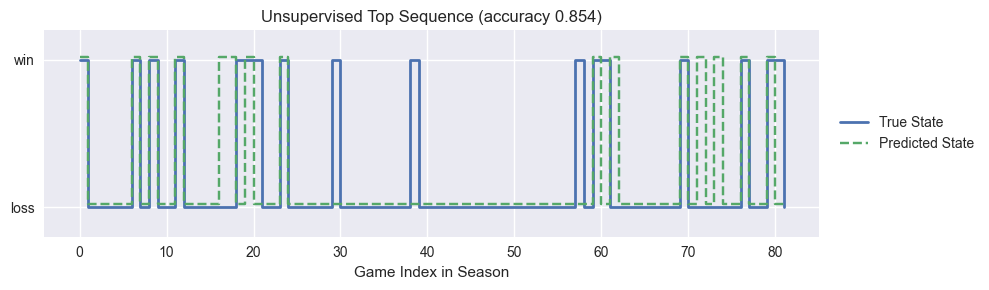

Median example (rank 29 of 60). visualizing sequence: season 2018, index 16, accuracy 0.732, length 82


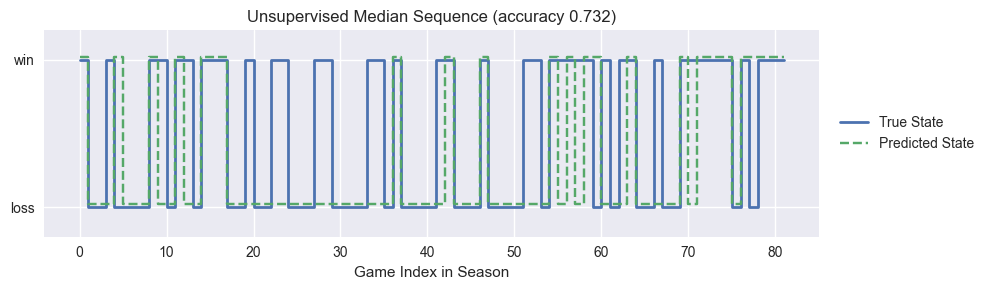

Worst example (rank 60 of 60). visualizing sequence: season 2018, index 7, accuracy 0.549, length 82


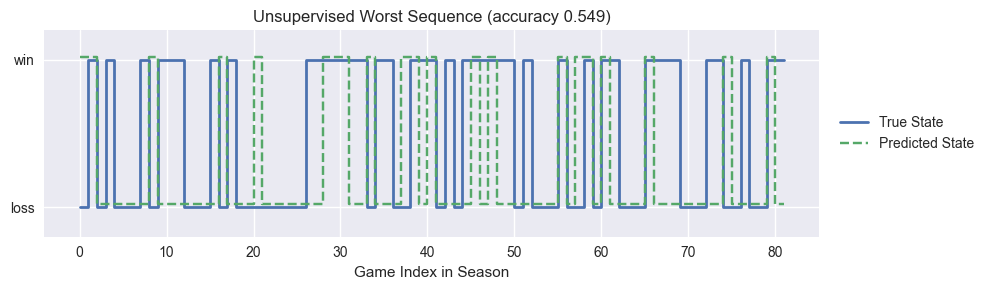

In [10]:
def get_example_positions(accs, window_size=5):
    # sort indices by accuracy in descending order
    sorted_positions = np.argsort(accs)[::-1]
    n = accs.size

    # choose one from the top 5 (or fewer if n < 5)
    top_end = min(window_size, n)
    top_candidates = sorted_positions[:top_end]
    top_pos = top_candidates[0]

    # choose one from the middle 5 (centered around the median rank when possible)
    mid_start = max(0, n // 2 - window_size // 2)
    mid_end = min(n, mid_start + window_size)
    middle_candidates = sorted_positions[mid_start:mid_end]
    middle_pos = middle_candidates[0]

    # choose one from the bottom 5 (or fewer if n < 5)
    bottom_start = max(0, n - window_size)
    bottom_candidates = sorted_positions[bottom_start:]
    bottom_pos = bottom_candidates[-1]

    categories = [
        ("Top", top_pos),
        ("Median", middle_pos),
        ("Worst", bottom_pos),
    ]

    return sorted_positions, categories


if per_seq_accs_supervised.size == 0:
    print("no per-sequence accuracies computed; run the viterbi and accuracy cells first")
else:
    # select one top-5, one middle-5, and one bottom-5 example
    sorted_positions_sup, categories_sup = get_example_positions(per_seq_accs_supervised)

    for category, pos in categories_sup:
        example_idx = int(per_seq_indices_supervised[pos])
        true_seq = test_states_supervised[example_idx]
        pred_seq = pred_paths_supervised[example_idx]

        T = min(true_seq.size, pred_seq.size)
        x = np.arange(T)

        rank = int(np.where(sorted_positions_sup == pos)[0][0]) + 1
        n_total = per_seq_accs_supervised.size

        print(
            f"{category} example (rank {rank} of {n_total}). "
            f"visualizing sequence: season {per_seq_seasons_supervised[pos]}, "
            f"index {example_idx}, accuracy {per_seq_accs_supervised[pos]:.3f}, length {T}"
        )

        fig, ax = plt.subplots(figsize=(10, 3))
        ax.step(x, true_seq[:T], where="post", label="True State", linewidth=2)
        ax.step(x, pred_seq[:T] + 0.02, where="post", label="Predicted State", linestyle="--")

        ax.set_ylim(-0.2, 1.2)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(["Loss", "Win"])
        ax.set_xlabel("Game Index in Season")
        ax.set_title(f"Supervised {category} Sequence (accuracy {per_seq_accs_supervised[pos]:.3f})")

        # place legend outside the plotting area on the right
        ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
        plt.tight_layout()
        plt.show()

if per_seq_accs_unsupervised.size == 0:
    print("no per-sequence accuracies computed; run the viterbi and accuracy cells first")
else:
    # select one top-5, one middle-5, and one bottom-5 example
    sorted_positions_unsup, categories_unsup = get_example_positions(per_seq_accs_unsupervised)

    for category, pos in categories_unsup:
        example_idx = int(per_seq_indices_unsupervised[pos])
        true_seq = test_states_unsupervised[example_idx]
        pred_seq = pred_paths_unsupervised[example_idx]

        T = min(true_seq.size, pred_seq.size)
        x = np.arange(T)

        rank = int(np.where(sorted_positions_unsup == pos)[0][0]) + 1
        n_total = per_seq_accs_unsupervised.size

        print(
            f"{category} example (rank {rank} of {n_total}). "
            f"visualizing sequence: season {per_seq_seasons_unsupervised[pos]}, "
            f"index {example_idx}, accuracy {per_seq_accs_unsupervised[pos]:.3f}, length {T}"
        )

        fig, ax = plt.subplots(figsize=(10, 3))
        ax.step(x, true_seq[:T], where="post", label="True State", linewidth=2)
        ax.step(x, pred_seq[:T] + 0.02, where="post", label="Predicted State", linestyle="--")

        ax.set_ylim(-0.2, 1.2)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(["loss", "win"])
        ax.set_xlabel("Game Index in Season")
        ax.set_title(f"Unsupervised {category} Sequence (accuracy {per_seq_accs_unsupervised[pos]:.3f})")

        # place legend outside the plotting area on the right
        ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
        plt.tight_layout()
        plt.show()

## best and worst sequences by accuracy


In [10]:
# sort sequences by accuracy and print a few best and worst examples
k = 5  # number of sequences to display in each group
print("(supervised)")
if per_seq_accs_supervised.size == 0:
    print("no non-empty test sequences to display")
else:
    sorted_idx = np.argsort(per_seq_accs_supervised)
    k = min(k, per_seq_accs_supervised.size)

    print("worst sequences:")
    for rank, idx in enumerate(sorted_idx[:k], start=1):
        seq_acc = per_seq_accs_supervised[idx]
        season = per_seq_seasons_supervised[idx]
        original_index = per_seq_indices_supervised[idx]
        seq_len = test_states_supervised[original_index].size
        print(
            f"  {rank}. season {season}, index {original_index}, "
            f"length {seq_len}, accuracy {seq_acc:.3f}"
        )

    print()
    print("best sequences:")
    for rank, idx in enumerate(sorted_idx[-k:][::-1], start=1):
        seq_acc = per_seq_accs_supervised[idx]
        season = per_seq_seasons_supervised[idx]
        original_index = per_seq_indices_supervised[idx]
        seq_len = test_states_supervised[original_index].size
        print(
            f"  {rank}. season {season}, index {original_index}, "
            f"length {seq_len}, accuracy {seq_acc:.3f}"
        )

print("(unsupervised)")
if per_seq_accs_unsupervised.size == 0:
    print("no non-empty test sequences to display")
else:
    sorted_idx = np.argsort(per_seq_accs_unsupervised)
    k = min(k, per_seq_accs_unsupervised.size)

    print("worst sequences:")
    for rank, idx in enumerate(sorted_idx[:k], start=1):
        seq_acc = per_seq_accs_unsupervised[idx]
        season = per_seq_seasons_unsupervised[idx]
        original_index = per_seq_indices_unsupervised[idx]
        seq_len = test_states_unsupervised[original_index].size
        print(
            f"  {rank}. season {season}, index {original_index}, "
            f"length {seq_len}, accuracy {seq_acc:.3f}"
        )

    print()
    print("best sequences:")
    for rank, idx in enumerate(sorted_idx[-k:][::-1], start=1):
        seq_acc = per_seq_accs_unsupervised[idx]
        season = per_seq_seasons_unsupervised[idx]
        original_index = per_seq_indices_unsupervised[idx]
        seq_len = test_states_unsupervised[original_index].size
        print(
            f"  {rank}. season {season}, index {original_index}, "
            f"length {seq_len}, accuracy {seq_acc:.3f}"
        )



(supervised)
worst sequences:
  1. season 2018, index 20, length 82, accuracy 0.524
  2. season 2018, index 23, length 82, accuracy 0.634
  3. season 2024, index 57, length 83, accuracy 0.639
  4. season 2018, index 29, length 82, accuracy 0.646
  5. season 2018, index 5, length 82, accuracy 0.671

best sequences:
  1. season 2018, index 14, length 82, accuracy 0.854
  2. season 2024, index 59, length 82, accuracy 0.841
  3. season 2024, index 51, length 82, accuracy 0.841
  4. season 2018, index 2, length 82, accuracy 0.841
  5. season 2024, index 39, length 82, accuracy 0.841
(unsupervised)
worst sequences:
  1. season 2018, index 7, length 82, accuracy 0.549
  2. season 2018, index 20, length 82, accuracy 0.561
  3. season 2024, index 38, length 81, accuracy 0.593
  4. season 2018, index 23, length 82, accuracy 0.622
  5. season 2024, index 36, length 82, accuracy 0.646

best sequences:
  1. season 2018, index 14, length 82, accuracy 0.854
  2. season 2024, index 39, length 82, accu

## aggregate performance by season


In [11]:
# compute per-season mean accuracy
if per_seq_accs_supervised.size == 0:
    print("no per-sequence accuracies available for season aggregation")
else:
    unique_seasons = np.unique(per_seq_seasons_supervised)
    season_means = []
    season_counts = []

    print("per-season accuracy summary (supervised):")
    for season in unique_seasons:
        mask = per_seq_seasons_supervised == season
        season_accs = per_seq_accs_supervised[mask]
        mean_acc = season_accs.mean()
        count = season_accs.size
        season_means.append(mean_acc)
        season_counts.append(count)
        print(
            f"  season {season}: mean accuracy {mean_acc:.3f} "
            f"over {count} sequences"
        )

    season_means = np.array(season_means)
    season_counts = np.array(season_counts)

# compute per-season mean accuracy
if per_seq_accs_unsupervised.size == 0:
    print("no per-sequence accuracies available for season aggregation")
else:
    unique_seasons = np.unique(per_seq_seasons_unsupervised)
    season_means = []
    season_counts = []

    print("per-season accuracy summary (unsupervised):")
    for season in unique_seasons:
        mask = per_seq_seasons_unsupervised == season
        season_accs = per_seq_accs_unsupervised[mask]
        mean_acc = season_accs.mean()
        count = season_accs.size
        season_means.append(mean_acc)
        season_counts.append(count)
        print(
            f"  season {season}: mean accuracy {mean_acc:.3f} "
            f"over {count} sequences"
        )

    season_means = np.array(season_means)
    season_counts = np.array(season_counts)


per-season accuracy summary (supervised):
  season 2018: mean accuracy 0.738 over 30 sequences
  season 2024: mean accuracy 0.744 over 30 sequences
per-season accuracy summary (unsupervised):
  season 2018: mean accuracy 0.716 over 30 sequences
  season 2024: mean accuracy 0.731 over 30 sequences


In [ ]:
# compute average number of games predicted correctly per test sequence, separated by holdout season
if per_seq_accs_supervised.size == 0:
    print("no per-sequence accuracies; run the viterbi and per-sequence evaluation cells first")
else:
    # build per-season lists of correct-game counts
    unique_seasons = np.unique(test_seasons_supervised)
    season_correct_counts = {season: [] for season in unique_seasons}

    for season, y_true, y_pred in zip(test_seasons_supervised, test_states_supervised, pred_paths_supervised):
        if y_true.size == 0 or y_pred.size == 0:
            continue
        T = min(y_true.size, y_pred.size)
        num_correct = int(np.sum(y_true[:T] == y_pred[:T]))
        season_correct_counts[season].append(num_correct)

    print("average number of games predicted correctly per test sequence by season (supervised):")
    for season in unique_seasons:
        counts = np.array(season_correct_counts[season])
        if counts.size == 0:
            continue
        avg_correct = counts.mean()
        print(
            f"  season {season}: avg correct {avg_correct:.2f} over {counts.size} sequences"
        )

# compute average number of games predicted correctly per test sequence, separated by holdout season
if per_seq_accs_unsupervised.size == 0:
    print("no per-sequence accuracies; run the viterbi and per-sequence evaluation cells first")
else:
    # build per-season lists of correct-game counts
    unique_seasons = np.unique(test_seasons_unsupervised)
    season_correct_counts = {season: [] for season in unique_seasons}

    for season, y_true, y_pred in zip(test_seasons_unsupervised, test_states_unsupervised, pred_paths_unsupervised):
        if y_true.size == 0 or y_pred.size == 0:
            continue
        T = min(y_true.size, y_pred.size)
        num_correct = int(np.sum(y_true[:T] == y_pred[:T]))
        season_correct_counts[season].append(num_correct)

    print("average number of games predicted correctly per test sequence by season (unsupervised):")
    for season in unique_seasons:
        counts = np.array(season_correct_counts[season])
        if counts.size == 0:
            continue
        avg_correct = counts.mean()
        print(
            f"  season {season}: avg correct {avg_correct:.2f} over {counts.size} sequences"
        )



average number of games predicted correctly per test sequence by season (supervised):
  season 2018: avg correct 60.53 over 30 sequences
  season 2024: avg correct 60.87 over 30 sequences
average number of games predicted correctly per test sequence by season (unsupervised):
  season 2018: avg correct 58.70 over 30 sequences
  season 2024: avg correct 59.80 over 30 sequences
